**Table of Contents**

- Model 1: Support Vector Machine, Logistic Regression, Random Forest

- Model 2: Bagged Support Vector Machine, Bagged Logistic Regression, Random Forest

- Model 3: XGBoost, LightGBM, CatBoost


In [ ]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 52 kB/s 


In [ ]:
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from skimage import feature
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

**Utility Functions**

In [ ]:
class Utils:
  def __init__(self):
    self.mapping = {0:'t-shirt/top',1:'trouser',2:'pullover',3:'dress',4:'coat',5:'sandal',6:'shirt',7:'sneaker',8:'bag',9:'ankle boot'}

  def reshape(self,data):
    """
    Reshape the data for plotting.
    """
    self.data = data
    data_array = np.array([i.reshape(28,28) for i in np.array(self.data.iloc[:,1:])])
    return data_array

  def process_img(self,pixel_data,edge_detection_):
    """
    Convert the img_path in the data file to pixel arrays and extract the labels, subjected to various 
    pre-processing steps

      Parameters:
        pixel_data (dataframe): pandas dataframe with pixel values
        edge_detection_ (bool,float): tuple containing whether it is implemented and the sigma parameter value
    """

    self.pixel_data = pixel_data
    self.edge_detection_ = edge_detection_

    imgs_flat = []

    n =  self.pixel_data.shape[0]

    for i in range(n):
      img_array = np.array(self.pixel_data.iloc[i,:]).reshape(28,28)

      if self.edge_detection_[0]==True:
        sigma_val = self.edge_detection_[1]
        img_array = feature.canny(img_array,sigma_val)

      imgs_flat.append(img_array.flatten())
    
    output_data = pd.DataFrame(np.array(imgs_flat))
    
    return output_data

**Data Preprocessing**

In [ ]:
# Load the data
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')

# Training set
X_train = train.iloc[:,1:]
y_train = train.iloc[:,:1]

# Testing set
X_test = test.iloc[:,1:]
y_test = test.iloc[:,:1]

In [ ]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Sample Data**

In [ ]:
process = Utils()
df_sample = pd.DataFrame()

for l in train['label'].unique():
  df_l = train[train.label==l].reset_index(drop=True)
  idx = np.random.randint(0,df_l.shape[0])
  df_i = df_l.iloc[idx:idx+1,:]
  df_sample = pd.concat([df_sample,df_i],axis=0)

df_sample = df_sample.reset_index(drop=True)
df_sample['label'] = df_sample['label'].map(process.mapping)

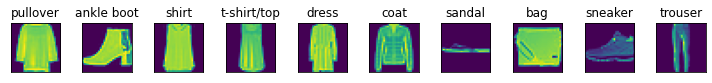

In [ ]:
sample_imgs = process.reshape(df_sample)

f,a = plt.subplots(1,10,figsize=(10,10))
for i in range(df_sample.shape[0]):
  a[i].imshow(sample_imgs[i])
  a[i].grid(False)
  a[i].set_xticks([])
  a[i].set_yticks([])
  a[i].set_title(df_sample.loc[i,'label'])
plt.tight_layout()
plt.show()

**Ensemble Model 1**

The first stage of this model involves

- Support vector machine classifier

- Random forest classifier

- Logistic regression

In the second stage, we use a voting classifier to select the winner of the first stage model outputs based on soft voting (select the label with the highest total predicted probablity). 

The first stage models are diverse, independent, and uncorrelated. 

Note that the model is trained on normalized data.

In [ ]:
# Support vector machine
model1_svc = SVC(probability=True,random_state=100,C=10,kernel='rbf')

# Random forest classifier
model1_rf = RandomForestClassifier(random_state=100,n_jobs=-1)

# Logistic regression
model1_lr = LogisticRegression(max_iter=1000,random_state=100,n_jobs=-1,multi_class='ovr')

# Voting classifier
model1_voting = VotingClassifier(estimators=[('svc',model1_svc),
                                             ('rf',model1_rf),
                                             ('lr',model1_lr)],voting='soft',n_jobs=-1)

# Assemble everything together
model1_pipeline = Pipeline([('voting',model1_voting)])

In [ ]:
# Implementation
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  model1_pipeline.fit(X_train_scaled,np.array(y_train).ravel())
  model1_pred = model1_pipeline.predict(X_test_scaled)
  pickle.dump(model1_pipeline,open('model1_pipeline.sav','wb'))

In [ ]:
# Evaluation
model1_report = classification_report(np.array(y_test).ravel(),model1_pred,digits=4,target_names=list(process.mapping.values()))
print(model1_report)

              precision    recall  f1-score   support

 t-shirt/top     0.8232    0.8660    0.8441      1000
     trouser     0.9869    0.9820    0.9845      1000
    pullover     0.8549    0.8310    0.8428      1000
       dress     0.9029    0.9300    0.9163      1000
        coat     0.8373    0.8800    0.8581      1000
      sandal     0.9733    0.9470    0.9600      1000
       shirt     0.7778    0.6860    0.7290      1000
     sneaker     0.9358    0.9480    0.9419      1000
         bag     0.9578    0.9760    0.9668      1000
  ankle boot     0.9497    0.9620    0.9558      1000

    accuracy                         0.9008     10000
   macro avg     0.9000    0.9008    0.8999     10000
weighted avg     0.9000    0.9008    0.8999     10000



**Ensemble Model 2**

We maintain the structure of the previous model, but add a bagging classifier to the output of support vector machine and logistic regression.

In [ ]:
# Support vector machine
model2_svc = SVC(probability=True,random_state=100,C=10,kernel='rbf')

# Random forest classifier
model2_rf = RandomForestClassifier(random_state=100,n_jobs=-1)

# Logistic regression
model2_lr = LogisticRegression(max_iter=1000,random_state=100,n_jobs=-1,multi_class='ovr')

# Voting classifier
model2_voting = VotingClassifier(estimators=[('svc_bagged',BaggingClassifier(model2_svc,n_jobs=-1)),
                                             ('rf',model2_rf),
                                             ('lr_bagged',BaggingClassifier(model2_lr,n_jobs=-1))],voting='soft',n_jobs=-1)

# Assemble everything together
model2_pipeline = Pipeline([('voting',model2_voting)])

In [ ]:
# Implementation
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  model2_pipeline.fit(X_train_scaled,np.array(y_train).ravel())
  model2_pred = model2_pipeline.predict(X_test_scaled)
  pickle.dump(model2_pipeline,open('model2_pipeline.sav','wb'))

In [ ]:
# Evaluation
model2_report = classification_report(np.array(y_test).ravel(),model2_pred,digits=4,target_names=list(process.mapping.values()))
print(model2_report)

              precision    recall  f1-score   support

 t-shirt/top     0.8188    0.8630    0.8403      1000
     trouser     0.9889    0.9810    0.9849      1000
    pullover     0.8490    0.8320    0.8404      1000
       dress     0.9056    0.9300    0.9176      1000
        coat     0.8416    0.8870    0.8637      1000
      sandal     0.9753    0.9460    0.9604      1000
       shirt     0.7782    0.6770    0.7241      1000
     sneaker     0.9338    0.9450    0.9394      1000
         bag     0.9532    0.9770    0.9649      1000
  ankle boot     0.9459    0.9610    0.9534      1000

    accuracy                         0.8999     10000
   macro avg     0.8990    0.8999    0.8989     10000
weighted avg     0.8990    0.8999    0.8989     10000



In [ ]:
from google.colab import files
files.download('model2_pipeline.sav')

**Ensemble Model 3**

In the first stage of model 3, we consider the following boosting models:

- XGBoost

- LightGBM

- CatBoost

We first tune each individual model using grid search cross validation. Then assemble the tuned models together in the second stage using a voting classifier like before.

*XGBoost*

In [ ]:
# XGBoost pipeline 
model3_xgb = Pipeline([('xgb',XGBClassifier(random_state=100,tree_method='gpu_hist',gpu_id=0,objective='multi:softmax',min_child_weight=1))])

# Grid search cv
params_xgb = [{'xgb__n_estimators':[500,1000],
               'xgb__learning_rate':[0.1,0.5],
               'xgb__max_depth':[5,10],
               'xgb__reg_lambda':[10,20]}]

model3_xgb_gs = GridSearchCV(model3_xgb,param_grid=params_xgb,scoring='accuracy',cv=3)

In [ ]:
# Implementation
with warnings.catch_warnings():
  model3_xgb_gs.fit(X_train_scaled,np.array(y_train).ravel())
  print('Best parameters for XGBoost are {}.'.format(model3_xgb_gs.best_params_))
  print('Best score on the training set is {}.'.format(model3_xgb_gs.score(X_train_scaled,np.array(y_train).ravel())))

Best parameters for XGBoost are {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 1000, 'xgb__reg_lambda': 10}.
Best score on the training set is 1.0.


*LightGBM*

Since grid search cross validation recommends `learning_rate` 0.1 and `n_estimators` 200 for both AdaBoost and XGBoost, we will use those value as given for LightGBM and focus on searching the ideal `max_depth`.

In [ ]:
#LightGBM pipeline
model3_lgbm = Pipeline([('lgbm',LGBMClassifier(random_state=100,objective='multiclass'))])

# Grid search cv
params_lgbm = [{'lgbm__n_estimators':[500,1000],
                'lgbm__learning_rate':[0.1,0.5],
                'lgbm__max_depth':[5,10]}]

model3_lgbm_gs = GridSearchCV(model3_lgbm,param_grid=params_lgbm,scoring='accuracy',cv=3)

In [ ]:
# Implementation
with warnings.catch_warnings():
  model3_lgbm_gs.fit(X_train_scaled,np.array(y_train).ravel())
  print('Best parameters for LightGBM are {}.'.format(model3_lgbm_gs.best_params_))
  print('Best score on the training set is {}.'.format(model3_lgbm_gs.score(X_train_scaled,np.array(y_train).ravel())))

Best parameters for LightGBM are {'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 1000}.
Best score on the training set is 1.0.


*CatBoost*

In [ ]:
#CatBoost pipeline
model3_cb = Pipeline([('cb',CatBoostClassifier(random_state=100,loss_function='MultiClass',iterations=1000,task_type='GPU',devices='0',verbose=False))])

# Grid search cv
params_cb = [{'cb__learning_rate':[0.1,0.5],
              'cb__depth':[4,6],
              'cb__l2_leaf_reg':[5,10]}]

model3_cb_gs = GridSearchCV(model3_cb,param_grid=params_cb,scoring='accuracy',cv=3)

In [ ]:
# Implementation
with warnings.catch_warnings():
  model3_cb_gs.fit(X_train_scaled,np.array(y_train).ravel())
  print('Best parameters for CatBoost are {}.'.format(model3_cb_gs.best_params_))
  print('Best score on the training set is {}.'.format(model3_cb_gs.score(X_train_scaled,np.array(y_train).ravel())))

Best parameters for CatBoost are {'cb__depth': 6, 'cb__l2_leaf_reg': 5, 'cb__learning_rate': 0.5}.
Best score on the training set is 0.9968666666666667.


*Assemble the Models*

In [ ]:
# XGBoost
model3_xgb_final = XGBClassifier(random_state=100,tree_method='gpu_hist',gpu_id=0,objective='multi:softmax',
                                 learning_rate=0.1,max_depth=5,n_estimators=1000,gamma=2,reg_lambda=10,min_child_weight=1)

# LightGBM
model3_lgbm_final = LGBMClassifier(random_state=100,objective='multiclass',learning_rate=0.1,
                                   max_depth=10,n_estimators=1000)

# CatBoost
model3_cb_final = CatBoostClassifier(random_state=100,loss_function='MultiClass',iterations=1000,
                                     task_type='GPU',devices='0',verbose=False,depth=6,learning_rate=0.5,
                                     l2_leaf_reg=5)

# Voting classifier
model3_voting = VotingClassifier(estimators=[('xgb',model3_xgb_final),
                                             ('lgbm',model3_lgbm_final),
                                             ('cb',model3_cb_final)],voting='soft',n_jobs=-1)

# Assemble everything together
model3_pipeline = Pipeline([('voting',model3_voting)])

In [ ]:
# Implementation
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  model3_pipeline.fit(X_train_scaled,np.array(y_train).ravel())
  model3_pred = model3_pipeline.predict(X_test_scaled)
  pickle.dump(model3_pipeline,open('model3_pipeline.sav','wb'))

In [ ]:
# Evaluation - report
model3_report = classification_report(np.array(y_test).ravel(),model3_pred,digits=4,target_names=list(process.mapping.values()))
print(model3_report)

              precision    recall  f1-score   support

 t-shirt/top     0.8539    0.8940    0.8735      1000
     trouser     0.9899    0.9850    0.9875      1000
    pullover     0.8640    0.8580    0.8610      1000
       dress     0.9203    0.9350    0.9276      1000
        coat     0.8672    0.8880    0.8775      1000
      sandal     0.9917    0.9610    0.9761      1000
       shirt     0.7961    0.7380    0.7660      1000
     sneaker     0.9463    0.9690    0.9575      1000
         bag     0.9780    0.9780    0.9780      1000
  ankle boot     0.9632    0.9680    0.9656      1000

    accuracy                         0.9174     10000
   macro avg     0.9171    0.9174    0.9170     10000
weighted avg     0.9171    0.9174    0.9170     10000



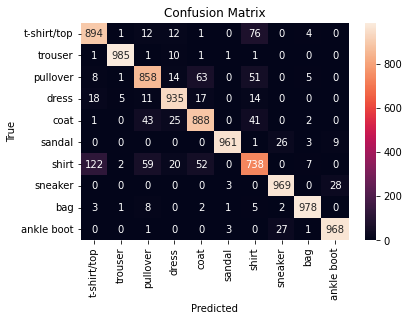

In [ ]:
# Evaluation - confusion matrix
labels = list(process.mapping.values())
confusion = confusion_matrix(np.array(y_test).ravel(),model3_pred)
sns.heatmap(confusion,annot=True,fmt='g',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()